# N-HITS Forecasting with Nixtla's NeuralForecast

## Dataset: KaggleWPGD

This notebook demonstrates how to use the N-HITS forecasting model described in:

*N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting*, [https://arxiv.org/abs/2201.12886](https://arxiv.org/abs/2201.12886)

The implementation we use is provided by Nixtla's NeuralForecast library:

+ for the base model [`NHITS`](https://nixtlaverse.nixtla.io/neuralforecast/models.nhits.html#nhits)
+ for the automodel [`AutoNHITS`](https://nixtlaverse.nixtla.io/neuralforecast/models.html#autonhits)


## Important note:

This notebook uses the following conda environments:

+ Under linux: tfm_cc, described in the tfm_cc.yml file (see environments folder).
+ Under macOS: tfm_cc_nixtla, described in the tfm_cc_nixtla.yml file (see environments folder). 

## Execution Notes:

The run times that appear below correspond to the execution of the notebook in a Linux machine under Ubuntu 22.04 LTS with Intel Core i7-10870H CPU (2.20GHz), 64GB of RAM, NVIDIA GeForce RTX 3060 Laptop GPU with 6Gb VRAM.

## Load basic libraries

**Warning:** Model specific libraries will be loaded below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import logging



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



## Load dataset

The data in this notebook comes from the Kaggle dataset:

[Wind Power Generation Data - Forecasting](https://www.kaggle.com/datasets/mubashirrahim/wind-power-generation-data-forecasting/data)

In [2]:
file_path = "../../data/kaggleWPGD/Location1.csv"
df = pd.read_csv(file_path, delimiter=',')
df.head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


### Set datetime format and index

In [3]:
df['time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:00')
df.drop(columns=['Time'], inplace=True)
df.set_index('time', inplace=True)
df.head()

,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
time,,,,,,,,,
2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2017-01-02 00:00:00 to 2021-12-31 23:00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperature_2m       43800 non-null  float64
 1   relativehumidity_2m  43800 non-null  int64  
 2   dewpoint_2m          43800 non-null  float64
 3   windspeed_10m        43800 non-null  float64
 4   windspeed_100m       43800 non-null  float64
 5   winddirection_10m    43800 non-null  int64  
 6   winddirection_100m   43800 non-null  int64  
 7   windgusts_10m        43800 non-null  float64
 8   Power                43800 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 3.3 MB


### Select a subset of the data


In [5]:
df = df.head(7248)

### Rename the columns

In [6]:
initial_columns = df.columns.tolist()
initial_columns

['temperature_2m',
 'relativehumidity_2m',
 'dewpoint_2m',
 'windspeed_10m',
 'windspeed_100m',
 'winddirection_10m',
 'winddirection_100m',
 'windgusts_10m',
 'Power']

In [7]:
df.rename(columns={'Power' : 'Active_Power', 'windspeed_10m' : 'Wind_speed_tower'}, inplace=True)
df = df[['Active_Power', 'Wind_speed_tower']]
df

,Active_Power,Wind_speed_tower
time,,
2017-01-02 00:00:00,0.1635,1.44
2017-01-02 01:00:00,0.1424,2.06
2017-01-02 02:00:00,0.1214,1.30
2017-01-02 03:00:00,0.1003,1.30
2017-01-02 04:00:00,0.0793,2.47
...,...,...
2017-10-30 19:00:00,0.6847,5.89
2017-10-30 20:00:00,0.6841,6.32
2017-10-30 21:00:00,0.6834,6.52


### Check for missing values and duplicated dates

There are no missing data in this dataset

In [8]:
print(df.isna().sum())

Active_Power        0
Wind_speed_tower    0
dtype: int64


In [9]:
duplicate_dates = df.index[df.index.duplicated(keep='first')]
print(f"Number of duplicate timestamps: {len(duplicate_dates)}")
print(duplicate_dates)

Number of duplicate timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)


In [10]:
expected = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing = expected.difference(df.index)
print("Missing timestamps:", missing)



Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='h')


In [11]:
missing_df = pd.DataFrame({'missing':missing})
missing_df['date'] = missing_df['missing'].dt.date
missing_df.value_counts('date').sort_index()

Series([], Name: count, dtype: int64)

### Target and exogenous variables

In [12]:
target = 'Active_Power'

features = [col for col in df.columns if col != target]
features = features[:1]
features


['Wind_speed_tower']

In [13]:
df = df[features + [target]]
df

,Wind_speed_tower,Active_Power
time,,
2017-01-02 00:00:00,1.44,0.1635
2017-01-02 01:00:00,2.06,0.1424
2017-01-02 02:00:00,1.30,0.1214
2017-01-02 03:00:00,1.30,0.1003
2017-01-02 04:00:00,2.47,0.0793
...,...,...
2017-10-30 19:00:00,5.89,0.6847
2017-10-30 20:00:00,6.32,0.6841
2017-10-30 21:00:00,6.52,0.6834


## Train / Validation / Test split

We select the following lengths for the train, validation, and test sets:

In [14]:
int(np.ceil(df.shape[0] * 0.8))

5799

In [15]:
train_len = 5800 # approx int(np.ceil(df.shape[0] * 0.8))
print(f"Train length: {train_len}")

val_len = (df.shape[0] - train_len) // 2
print(f"Validation length: {val_len}")

test_len = df.shape[0] - train_len - val_len
print(f"Test length: {test_len}")

Train length: 5800
Validation length: 724
Test length: 724


And we split the time series into train, validation, and test sets:

In [16]:
train_df = df.iloc[:train_len]
train_df

,Wind_speed_tower,Active_Power
time,,
2017-01-02 00:00:00,1.44,0.1635
2017-01-02 01:00:00,2.06,0.1424
2017-01-02 02:00:00,1.30,0.1214
2017-01-02 03:00:00,1.30,0.1003
2017-01-02 04:00:00,2.47,0.0793
...,...,...
2017-08-31 11:00:00,4.83,0.6155
2017-08-31 12:00:00,5.15,0.5935
2017-08-31 13:00:00,5.47,0.5536


In [17]:
val_df = df.iloc[train_len:(train_len + val_len)]
val_df

,Wind_speed_tower,Active_Power
time,,
2017-08-31 16:00:00,5.87,0.4339
2017-08-31 17:00:00,5.19,0.3940
2017-08-31 18:00:00,4.26,0.3605
2017-08-31 19:00:00,2.21,0.3334
2017-08-31 20:00:00,2.55,0.3063
...,...,...
2017-09-30 15:00:00,2.12,0.0907
2017-09-30 16:00:00,2.42,0.0991
2017-09-30 17:00:00,2.10,0.1076


In [18]:
test_df = df.iloc[(train_len + val_len):]
test_df

,Wind_speed_tower,Active_Power
time,,
2017-09-30 20:00:00,1.80,0.1357
2017-09-30 21:00:00,1.71,0.1453
2017-09-30 22:00:00,1.44,0.1548
2017-09-30 23:00:00,1.40,0.1644
2017-10-01 00:00:00,2.20,0.1739
...,...,...
2017-10-30 19:00:00,5.89,0.6847
2017-10-30 20:00:00,6.32,0.6841
2017-10-30 21:00:00,6.52,0.6834


## Time series split visualization

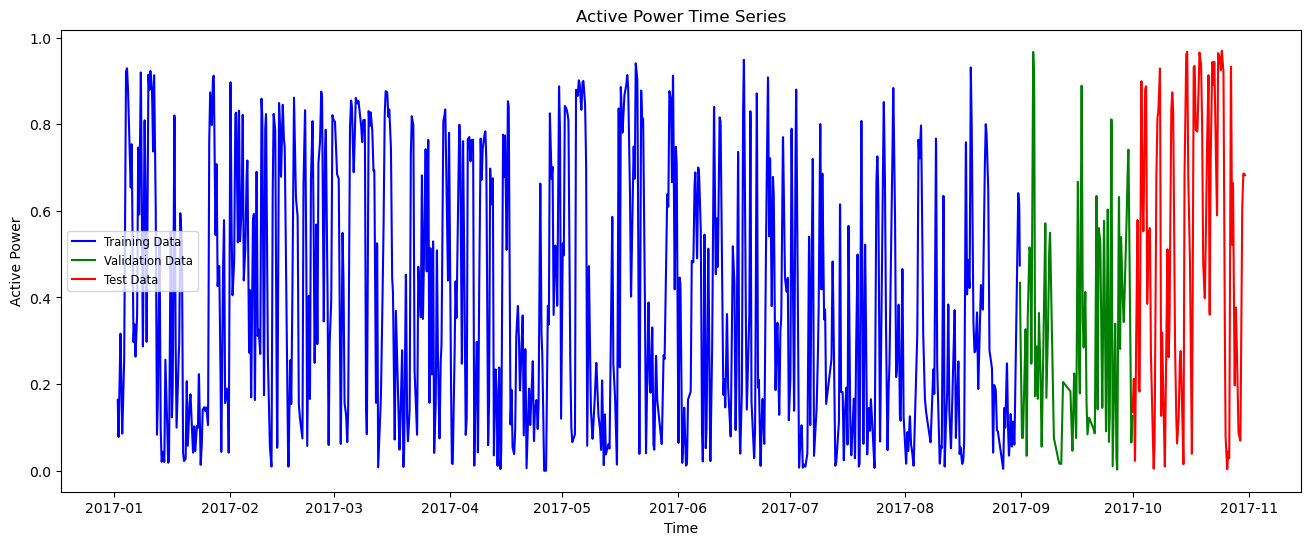

In [19]:
plt.figure(figsize=(16, 6))
plt.plot(train_df["Active_Power"], label="Training Data", color='blue')
plt.plot(val_df["Active_Power"], label="Validation Data", color='green')
plt.plot(test_df["Active_Power"], label="Test Data", color='red')
plt.title("Active Power Time Series")
plt.xlabel("Time")
plt.ylabel("Active Power")
plt.legend(fontsize='small')

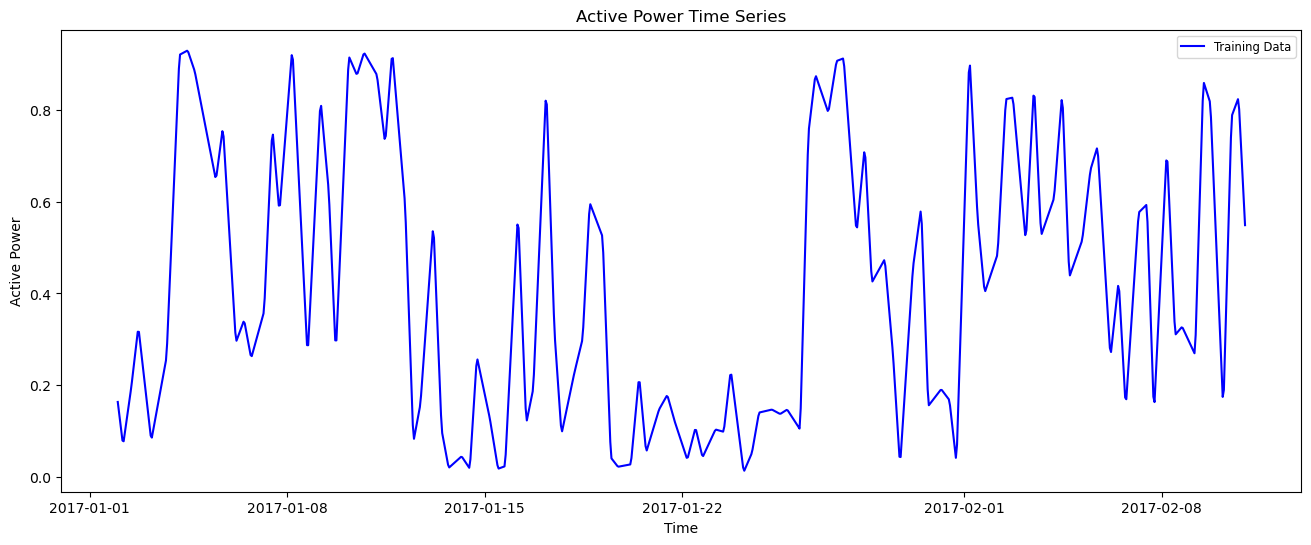

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(train_df["Active_Power"].head(960), label="Training Data", color='blue')
# plt.plot(val_df["Active_Power"].head(240), label="Validation Data", color='green')
# plt.plot(test_df["Active_Power"], label="Test Data", color='red')
plt.title("Active Power Time Series")
plt.xlabel("Time")
plt.ylabel("Active Power")
plt.legend(fontsize='small')

We will also create copies of the train, validation, and test sets to use them later in the notebook.

In [21]:
train_df_original = train_df.copy()
val_df_original = val_df.copy()
test_df_original = test_df.copy()

## Data scaling

We apply the min-max scaler fitted to the training set to the train, validation, and test sets (to avoid data leakage). 

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.set_output(transform='pandas')

scaler.fit(train_df)
train_df = scaler.transform(train_df)

val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

Let us check the result

In [23]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wind_speed_tower,5800.0,0.275745,0.127310,0.0,0.184488,0.249247,0.348645,1.0
Active_Power,5800.0,0.407862,0.287194,0.0,0.149394,0.349394,0.669188,1.0


### Nixtla Dataset Format

Convert to NeuralForecast format (ds, y, unique_id)

In [24]:


train_df_nf = train_df.copy()
train_df_nf = train_df_nf.rename(columns={target: 'y'})
train_df_nf['ds'] = train_df_nf.index

train_df_nf['unique_id'] = 'series_1'


Move ds and unique_id to front

In [25]:

train_df_nf = train_df_nf[['unique_id', 'ds', 'y'] + features]
train_df_nf


,unique_id,ds,y,Wind_speed_tower
time,,,,
2017-01-02 00:00:00,series_1,2017-01-02 00:00:00,0.172377,0.108434
2017-01-02 01:00:00,series_1,2017-01-02 01:00:00,0.150132,0.155120
2017-01-02 02:00:00,series_1,2017-01-02 02:00:00,0.127992,0.097892
2017-01-02 03:00:00,series_1,2017-01-02 03:00:00,0.105746,0.097892
2017-01-02 04:00:00,series_1,2017-01-02 04:00:00,0.083606,0.185994
...,...,...,...,...
2017-08-31 11:00:00,series_1,2017-08-31 11:00:00,0.648919,0.363705
2017-08-31 12:00:00,series_1,2017-08-31 12:00:00,0.625725,0.387801
2017-08-31 13:00:00,series_1,2017-08-31 13:00:00,0.583658,0.411898


Same for validation and test sets

In [26]:
val_df_nf = val_df.copy()
val_df_nf = val_df_nf.rename(columns={target: 'y'})
val_df_nf['ds'] = val_df_nf.index

val_df_nf['unique_id'] = 'series_1'

val_df_nf = val_df_nf[['unique_id', 'ds', 'y'] + features]
val_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2017-08-31 16:00:00,series_1,2017-08-31 16:00:00,0.457459,0.442018
2017-08-31 17:00:00,series_1,2017-08-31 17:00:00,0.415393,0.390813
2017-08-31 18:00:00,series_1,2017-08-31 18:00:00,0.380074,0.320783
2017-08-31 19:00:00,series_1,2017-08-31 19:00:00,0.351502,0.166416
2017-08-31 20:00:00,series_1,2017-08-31 20:00:00,0.322931,0.192018
...,...,...,...,...
2017-09-30 15:00:00,series_1,2017-09-30 15:00:00,0.095625,0.159639
2017-09-30 16:00:00,series_1,2017-09-30 16:00:00,0.104481,0.182229
2017-09-30 17:00:00,series_1,2017-09-30 17:00:00,0.113442,0.158133


In [27]:
test_df_nf = test_df.copy()
test_df_nf = test_df_nf.rename(columns={target: 'y'})
test_df_nf['ds'] = test_df_nf.index

test_df_nf['unique_id'] = 'series_1'

test_df_nf = test_df_nf[['unique_id', 'ds', 'y'] + features]
test_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2017-09-30 20:00:00,series_1,2017-09-30 20:00:00,0.143068,0.135542
2017-09-30 21:00:00,series_1,2017-09-30 21:00:00,0.153189,0.128765
2017-09-30 22:00:00,series_1,2017-09-30 22:00:00,0.163205,0.108434
2017-09-30 23:00:00,series_1,2017-09-30 23:00:00,0.173326,0.105422
2017-10-01 00:00:00,series_1,2017-10-01 00:00:00,0.183342,0.165663
...,...,...,...,...
2017-10-30 19:00:00,series_1,2017-10-30 19:00:00,0.721877,0.443524
2017-10-30 20:00:00,series_1,2017-10-30 20:00:00,0.721244,0.475904
2017-10-30 21:00:00,series_1,2017-10-30 21:00:00,0.720506,0.490964


Create a joint dataset with train and validation to fit into Nixtla's framework.

In [28]:
train_val_df = pd.concat([train_df_nf, val_df_nf], axis=0)
train_val_df.reset_index(drop=True, inplace=True)
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6524 entries, 0 to 6523
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         6524 non-null   object        
 1   ds                6524 non-null   datetime64[ns]
 2   y                 6524 non-null   float64       
 3   Wind_speed_tower  6524 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 204.0+ KB


And similarly a full dataset with train, validation and test sets.

In [29]:
full_df_nf = pd.concat([train_df_nf, val_df_nf, test_df_nf], axis=0)
full_df_nf.reset_index(drop=True, inplace=True)
full_df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         7248 non-null   object        
 1   ds                7248 non-null   datetime64[ns]
 2   y                 7248 non-null   float64       
 3   Wind_speed_tower  7248 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 226.6+ KB


## Set the forecast horizon and input length

In [30]:
horizon = 3
input_size = 6

# AutoNHits

Our first step is to fit the auto model, which automatically selects the best hyperparameters for the model using Optuna as optimization framework.

In [31]:
import logging

import optuna
# import ray.tune as tune
import torch

from neuralforecast import NeuralForecast

from neuralforecast.losses.pytorch import MAE

from neuralforecast.models import NHITS
from neuralforecast import NeuralForecast

In [32]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

Check if CUDA is available (Linux machines)

In [33]:
if torch.cuda.is_available():
    print(torch.cuda.device_count(), torch.cuda.current_device(),torch.cuda.get_device_name(0))

1 0 NVIDIA GeForce RTX 3060 Laptop GPU


## Optuna for hyperparameter tuning

#### Define the objective function along with the hyperparameter space.


In [34]:
from neuralforecast.models import NHITS

In [35]:
%%capture

logging.getLogger("lightning_fabric.utilities.seed").setLevel(logging.WARNING)

start_time = time.time()

model = NHITS(
    activation='Sigmoid',
    h=horizon,
    hist_exog_list = ['Wind_speed_tower'],
    scaler_type='standard',
    input_size=input_size,
    loss=MAE(),
    max_steps=300,
    random_seed=42,
    # **best_params
    stack_types = ['identity', 'identity', 'identity', 'identity'],
    n_blocks = [4, 1, 1, 1], 
    mlp_units = [[512, 512], [512, 512], [512, 512], [512, 512]], 
    n_pool_kernel_size = [2, 2, 2, 1],
    n_freq_downsample = [8, 4, 2, 1],
    enable_progress_bar=False
)

nf = NeuralForecast(models=[model], freq='H')

nf.fit(df=train_val_df)

end_time = time.time()

2025-06-17 20:57:02.187804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750186622.203289   22413 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750186622.207889   22413 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 20:57:02.222022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
elapsed_time = end_time - start_time
print(f"⏱️ Elapsed time: {elapsed_time / 60:.2f} minutes")

⏱️ Elapsed time: 0.13 minutes


In [37]:
# %%capture

# %%time

# cv_df = nf.cross_validation(train_val_df, n_windows=20, step_size=h, verbose=1, refit=True)
# cv_df

In [38]:
# from sklearn.metrics import mean_absolute_error as sk_MAE
# grouped_mae = cv_df.groupby("cutoff").apply(lambda g: sk_MAE(g["NHITS"], g["y"])).reset_index(name="mae")
# grouped_mae
# grouped_mae['mae'].mean()

In [39]:
from neuralforecast.losses.pytorch import MAE
    

def create_model(trial: optuna.trial.Trial):

    print(f"----------------------------------")
    print(f"Creating model with trial number: {trial.number}")
    n_stacks = trial.suggest_int("num_stacks", 1, 4)
    print(f"Number of stacks: {n_stacks}")

    mlp_choices = [[64, 64], [128, 128], [256, 256], [512, 512]]
    n_blocks =[trial.suggest_int(f"num_blocks_stck_{i}", 1, 4) for i in range(n_stacks)]
    print(f"Number of blocks per stack: {n_blocks}")
    mlp_units = [trial.suggest_categorical("mlp_units", mlp_choices) for _ in range(n_stacks)]
    print(f"MLP units per stack: {mlp_units}")
    


    model = NHITS(
    activation='Sigmoid', 
    h=horizon,
    hist_exog_list = ['Wind_speed_tower'],
    scaler_type='standard',
    input_size=input_size,
    loss=MAE(),
    max_steps=300,
    random_seed=42,
    #################
    # print(f"Number of stacks: {Num_stacks}")
    stack_types = ['identity'] * n_stacks,
    n_blocks = n_blocks, 
    # mlp_units = [[512, 512] for _ in range(n_stacks)], 
    mlp_units = mlp_units,
    n_pool_kernel_size = [2] * (n_stacks - 1) + [1],
    n_freq_downsample = [2**k for k in range(n_stacks - 1, -1, -1)])
    # learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    

    return model

In [40]:
def objective(trial):
    model = create_model(trial)
    nf = NeuralForecast(models=[model], freq='H')
    print("Entering CV")
    cv_df = nf.cross_validation(train_val_df, n_windows=10, step_size=horizon, verbose=2, refit=True)
    print("Exiting CV")
    print(f"----------------------------------")

    # norm_pred = ((cv_df["NHITS"] - np.min(cv_df["NHITS"])) / (np.max(cv_df["NHITS"]) - np.min(cv_df["NHITS"])))
    # return (norm_pred - cv_df["y"]).abs().mean()
    # winsor_pred = np.clip(norm_pred, 0, 1)
    # return (winsor_pred - cv_df["y"]).abs().mean()
    
    return (cv_df["NHITS"] - cv_df["y"]).abs().mean()


#### Initiate a study object via the create_study() function.

In [41]:
study = optuna.create_study(direction='minimize')

#### Perform hyperparameter tuning by calling the optimize() method on the study object.


In [42]:
%%capture

logging.getLogger("lightning_fabric.utilities.seed").setLevel(logging.WARNING)

start_time = time.time()

study.optimize(objective, n_trials=100, n_jobs=1)

end_time = time.time()

In [43]:
elapsed_time = end_time - start_time
print(f"⏱️ Elapsed time: {elapsed_time / 60:.2f} minutes")

⏱️ Elapsed time: 74.71 minutes


In [44]:
best_params = study.best_params
best_params

{'num_stacks': 1, 'num_blocks_stck_0': 3, 'mlp_units': [512, 512]}

In [45]:
# DONE

n_stacks = best_params['num_stacks']
print(f"Number of stacks: {n_stacks}")
n_blocks = [best_params[f'num_blocks_stck_{i}'] for i in range(n_stacks)]
print(f"Number of blocks per stack: {n_blocks}")
mlp_units = [best_params['mlp_units'] for _ in range(n_stacks)]
print(f"MLP units per stack: {mlp_units}")


Number of stacks: 1
Number of blocks per stack: [3]
MLP units per stack: [[512, 512]]


# NHits modeling

Using the best hyperparameters we can now fit a final model. This is done by passing the best hyperparameters to the model and then fitting it to the training + validation set. 


In [46]:
%%capture

model = NHITS(
    activation='Sigmoid',
    h=horizon,
    hist_exog_list = ['Wind_speed_tower'],
    scaler_type='standard',
    input_size=input_size,
    loss=MAE(),
    max_steps=300,
    random_seed=42,
    # **best_params
    stack_types = ['identity'] * n_stacks,
    enable_progress_bar=True,
    mlp_units = mlp_units,
    n_blocks = n_blocks, 
    n_pool_kernel_size = [2] * (n_stacks - 1) + [1],
    n_freq_downsample = [2**k for k in range(n_stacks - 1, -1, -1)])

nf = NeuralForecast(models=[model], freq='H')

nf.fit(df=train_val_df, verbose=True)

# Model Performance Evaluation

We create the rolling_df dataframe that contains the series data up to the time instant in which we make a prediction that corresponds to the first time instant in the test set. That prediction corresponds to the maximum value of the prediction horizon. 

In [47]:
rolling_df = full_df_nf.iloc[:(train_len + val_len + 1 - horizon)]
rolling_df.tail(2)

,unique_id,ds,y,Wind_speed_tower
6520,series_1,2017-09-30 16:00:00,0.104481,0.182229
6521,series_1,2017-09-30 17:00:00,0.113442,0.158133


Now to start the evaluation we fit the model to this dataset and get the predictions. We will not use all of them, only the last.

In [48]:
%%capture 

logging.getLogger("lightning_fabric.utilities.seed").setLevel(logging.WARNING)

nf.fit(df=rolling_df)

In [49]:
%%capture

rolling_preds = nf.predict()


In [50]:
rolling_preds

,unique_id,ds,NHITS
0,series_1,2017-09-30 18:00:00,0.122224
1,series_1,2017-09-30 19:00:00,0.131415
2,series_1,2017-09-30 20:00:00,0.139566


Note the last of these predictions corresponds to the first time instant in the test set. 

Now we create a dictionary (of dataframes) to store the predictions for each value k from 1 to the max of the prediction horizon. The weird (k-1):k bit below is to prevent pandas from collapsing the row into a series!

In [51]:
preds_df = {}
for k in range(1, horizon + 1):
    preds_df_name = str(k) + "h"  # String variable for the new name
    preds_df[preds_df_name] = rolling_preds.copy().iloc[(k-1):k, :]



Initially we store the predictions we obtained above in the dictionary (only the last one of these will actually be useful for comparison with the test set, but the others serve the purpose of dictionary initialisation).

In [52]:
preds_df['1h']

,unique_id,ds,NHITS
0,series_1,2017-09-30 18:00:00,0.122224


In [53]:
preds_df['2h']

,unique_id,ds,NHITS
1,series_1,2017-09-30 19:00:00,0.131415


In [54]:
preds_df['3h']

,unique_id,ds,NHITS
2,series_1,2017-09-30 20:00:00,0.139566


The main tool for evaluation is the for loop below. In each iteration we add one time instant to the rolling_df dataframe and then we fit the model to this dataframe. We then obtain the predictions for this augmented dataset and our forecasting horizon. And we store each  of them in the corresponing dataframe inside the dictionary. 

In [55]:
%%capture

logging.getLogger("lightning_fabric.utilities.seed").setLevel(logging.WARNING)

start_time = time.time()

# for k in range(2, 50): # for testing
for k in range(2, len(test_df_nf) + horizon):
    # rolling_df = pd.concat([train_df_nf, val_df_nf, test_df_nf.iloc[:k]])
    rolling_df = full_df_nf.iloc[:(train_len + val_len + k - horizon)]
    # print(rolling_df.tail(1))
    # print(rolling_df.shape)
    nf.fit(df=rolling_df)
    rolling_preds = nf.predict()
    # print(rolling_preds)
    for h in range(1, horizon + 1):
        preds_df[f'{h}h'] = pd.concat([preds_df[f'{h}h'], rolling_preds.iloc[(h - 1):h,:]], axis=0)

    print(f"k =  {k}")
    print("#" * 20)       



end_time = time.time()

In [56]:
print(f"⏱️ Elapsed time: {elapsed_time / 60:.2f} minutes")

⏱️ Elapsed time: 74.71 minutes


For ease of comparison and plotting we reindex the predictions dataframes in the dictionary to use ds as index.

In [57]:
for h in range(1, horizon + 1):
    preds_df[f'{h}h'].set_index('ds', inplace=True)

After doing that they look like this:

In [58]:
preds_df['1h']['NHITS'] = np.clip(preds_df['1h']['NHITS'], 0, 1) 

In [59]:
preds_df['2h']['NHITS'] = np.clip(preds_df['2h']['NHITS'], 0, 1)

In [60]:
preds_df['3h']['NHITS'] = np.clip(preds_df['3h']['NHITS'], 0, 1)

In [61]:
# test_df_nf.tail(3)

Let us plot the predictions against the test set values.

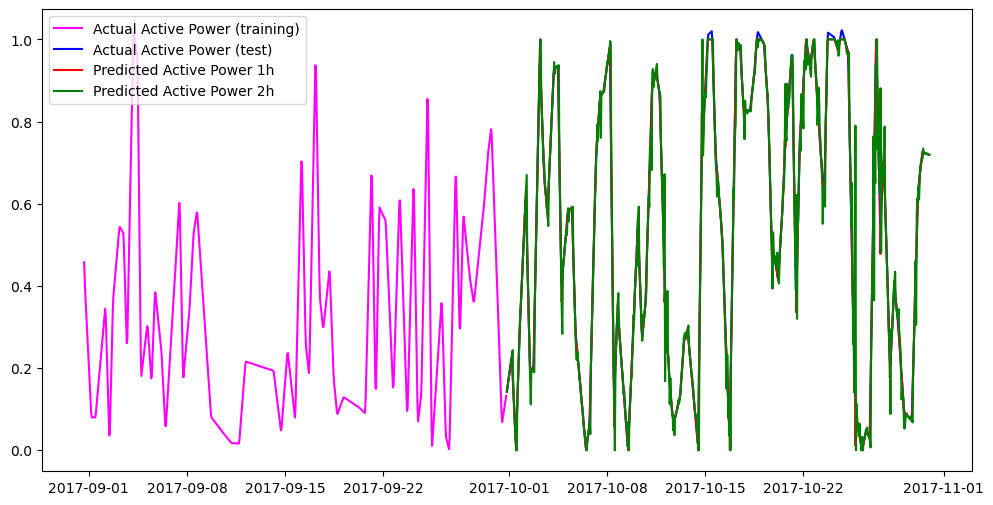

In [62]:
%matplotlib inline

plt.figure(figsize=(12, 6))
# plt.plot(val_df_nf["y"].tail(20), label="Actual Active Power (training)", color='magenta')
# plt.plot(test_df_nf["y"].head(20), label="Actual Active Power (test)", color='blue')
plt.plot(val_df_nf["y"], label="Actual Active Power (training)", color='magenta')
plt.plot(test_df_nf["y"], label="Actual Active Power (test)", color='blue')
plt.plot(preds_df['1h']['NHITS'][2:], label="Predicted Active Power 1h", color='red')
plt.plot(preds_df['2h']['NHITS'][1:], label="Predicted Active Power 2h", color='green')
# plt.plot(preds_df['3h']['NHITS'], label="Predicted Active Power 3h", color='orange')

plt.legend()
plt.show();plt.close()


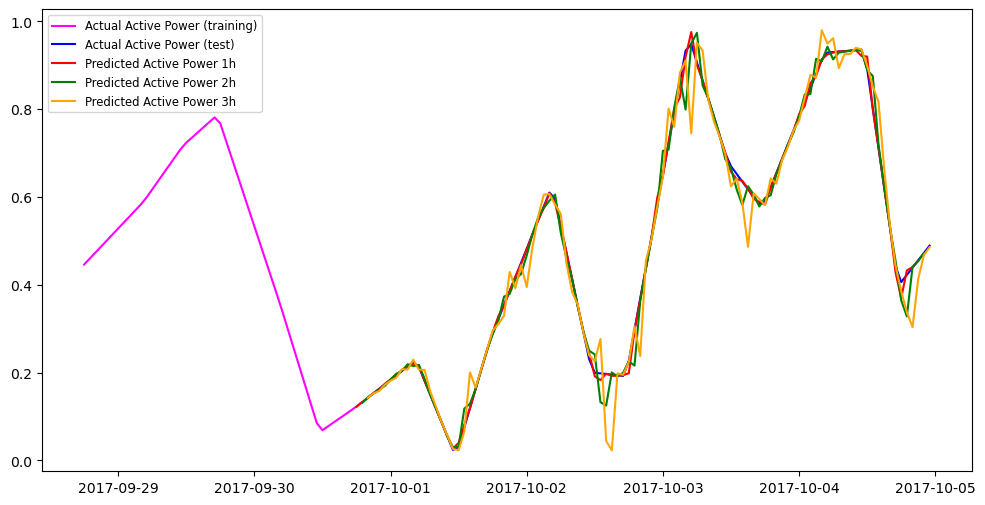

In [107]:
%matplotlib inline

plt.figure(figsize=(12, 6))
# plt.plot(val_df_nf["y"].tail(20), label="Actual Active Power (training)", color='magenta')
# plt.plot(test_df_nf["y"].head(20), label="Actual Active Power (test)", color='blue')
plt.plot(val_df_nf["y"].tail(50), label="Actual Active Power (training)", color='magenta')
plt.plot(test_df_nf["y"].head(100), label="Actual Active Power (test)", color='blue')
plt.plot(preds_df['1h']['NHITS'].head(100), label="Predicted Active Power 1h", color='red')
plt.plot(preds_df['2h']['NHITS'].head(100), label="Predicted Active Power 2h", color='green')
plt.plot(preds_df['3h']['NHITS'].head(100), label="Predicted Active Power 3h", color='orange')

plt.legend(fontsize='small')
plt.show();plt.close()


### MAE computation

We will next compute the MAE for each of the predictions in the dictionary. The trickiest part here is to ensure that the predictions are aligned with the test set. 

In [108]:
from sklearn.metrics import mean_absolute_error

In [109]:
test_df_nf.index.min(), test_df_nf.index.max()

(Timestamp('2017-09-30 20:00:00'), Timestamp('2017-10-30 23:00:00'))

In [110]:
test_df_nf['Wind_speed_tower']

time
2017-09-30 20:00:00    0.135542
2017-09-30 21:00:00    0.128765
2017-09-30 22:00:00    0.108434
2017-09-30 23:00:00    0.105422
2017-10-01 00:00:00    0.165663
                         ...   
2017-10-30 19:00:00    0.443524
2017-10-30 20:00:00    0.475904
2017-10-30 21:00:00    0.490964
2017-10-30 22:00:00    0.476657
2017-10-30 23:00:00    0.463102
Name: Wind_speed_tower, Length: 724, dtype: float64

In [111]:
mae1h_df = preds_df['1h'].copy()[2:][['NHITS']]
mae1h_df


,NHITS
ds,
2017-09-30 20:00:00,0.143255
2017-09-30 21:00:00,0.152949
2017-09-30 22:00:00,0.161771
2017-09-30 23:00:00,0.174423
2017-10-01 00:00:00,0.184522
...,...
2017-10-30 19:00:00,0.721681
2017-10-30 20:00:00,0.721199
2017-10-30 21:00:00,0.720640


We need to add the exogenous variables as they were used by the scaler. 

In [112]:
mae1h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values)
mae1h_df

,Wind_speed_tower,NHITS
ds,,
2017-09-30 20:00:00,0.135542,0.143255
2017-09-30 21:00:00,0.128765,0.152949
2017-09-30 22:00:00,0.108434,0.161771
2017-09-30 23:00:00,0.105422,0.174423
2017-10-01 00:00:00,0.165663,0.184522
...,...,...
2017-10-30 19:00:00,0.443524,0.721681
2017-10-30 20:00:00,0.475904,0.721199
2017-10-30 21:00:00,0.490964,0.720640


In [113]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae1h_df)[:,1], test_df_original["Active_Power"])

0.006674091426698358

#### Mae for 2h preddictions

In [114]:
mae2h_df = preds_df['2h'].copy()[1:][:-1][['NHITS']]
mae2h_df


,NHITS
ds,
2017-09-30 20:00:00,0.142033
2017-09-30 21:00:00,0.152502
2017-09-30 22:00:00,0.161576
2017-09-30 23:00:00,0.169637
2017-10-01 00:00:00,0.184456
...,...
2017-10-30 19:00:00,0.721748
2017-10-30 20:00:00,0.720069
2017-10-30 21:00:00,0.720531


In [115]:
mae2h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values)
mae2h_df

,Wind_speed_tower,NHITS
ds,,
2017-09-30 20:00:00,0.135542,0.142033
2017-09-30 21:00:00,0.128765,0.152502
2017-09-30 22:00:00,0.108434,0.161576
2017-09-30 23:00:00,0.105422,0.169637
2017-10-01 00:00:00,0.165663,0.184456
...,...,...
2017-10-30 19:00:00,0.443524,0.721748
2017-10-30 20:00:00,0.475904,0.720069
2017-10-30 21:00:00,0.490964,0.720531


In [117]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae2h_df)[:,1], test_df_original["Active_Power"])

0.02290388513652618

#### Mae for 3h preddictions

In [118]:
mae3h_df = preds_df['3h'].copy()[:-2][['NHITS']]
mae3h_df


,NHITS
ds,
2017-09-30 20:00:00,0.142487
2017-09-30 21:00:00,0.152598
2017-09-30 22:00:00,0.158074
2017-09-30 23:00:00,0.172433
2017-10-01 00:00:00,0.181613
...,...
2017-10-30 19:00:00,0.721319
2017-10-30 20:00:00,0.721116
2017-10-30 21:00:00,0.717298


In [119]:
mae3h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values)
mae3h_df

,Wind_speed_tower,NHITS
ds,,
2017-09-30 20:00:00,0.135542,0.142487
2017-09-30 21:00:00,0.128765,0.152598
2017-09-30 22:00:00,0.108434,0.158074
2017-09-30 23:00:00,0.105422,0.172433
2017-10-01 00:00:00,0.165663,0.181613
...,...,...
2017-10-30 19:00:00,0.443524,0.721319
2017-10-30 20:00:00,0.475904,0.721116
2017-10-30 21:00:00,0.490964,0.717298


In [120]:
mean_absolute_error(scaler.inverse_transform(mae3h_df)[:,1], test_df_original["Active_Power"])

0.04667031221239267